# Positions and Overtakes

## Import libraries

In [6]:
import fastf1
import matplotlib.pyplot as plt
import pandas as pd
from general_utils import *

## Positions

In [6]:
results_df = pd.read_csv('data/gps_2024_season_results.csv')
results_df = results_df[['Abbreviation', 'ClassifiedPosition', 'GridPosition', 'Status', 'EventName']]
results_df = results_df.rename(columns={'Abbreviation': 'Driver'})
results_df.head()

Driver ClassifiedPosition  GridPosition    Status           EventName
0    VER                  1           1.0  Finished  Bahrain Grand Prix
1    PER                  2           5.0  Finished  Bahrain Grand Prix
2    SAI                  3           4.0  Finished  Bahrain Grand Prix
3    LEC                  4           2.0  Finished  Bahrain Grand Prix
4    RUS                  5           3.0  Finished  Bahrain Grand Prix

### Positions gained

In [17]:
pos_gain_df = results_df.copy()
pos_gain_df.head()

Driver ClassifiedPosition  GridPosition    Status           EventName
0    VER                  1           1.0  Finished  Bahrain Grand Prix
1    PER                  2           5.0  Finished  Bahrain Grand Prix
2    SAI                  3           4.0  Finished  Bahrain Grand Prix
3    LEC                  4           2.0  Finished  Bahrain Grand Prix
4    RUS                  5           3.0  Finished  Bahrain Grand Prix

In [18]:
def calculate_positions(row):
    try:
        # Try converting the value to a float
        classified_position = float(row['ClassifiedPosition'])
        return row['GridPosition'] - classified_position
    except ValueError:
        # If conversion fails, return the original value
        return row['ClassifiedPosition']

In [19]:
# Apply the function row-wise
pos_gain_df['GainedPositions'] = pos_gain_df.apply(calculate_positions, axis=1)

In [20]:
pos_gain_df.sample(5)

Driver ClassifiedPosition  GridPosition    Status              EventName  \
333    OCO                 15           0.0    +1 Lap  Azerbaijan Grand Prix   
109    HUL                 11           9.0  Finished       Miami Grand Prix   
256    OCO                 18          19.0    +1 Lap   Hungarian Grand Prix   
10     ZHO                 11          17.0    +1 Lap     Bahrain Grand Prix   
275    SAR                 17          18.0  Finished     Belgian Grand Prix   

    GainedPositions  
333           -15.0  
109            -2.0  
256             1.0  
10              6.0  
275             1.0

Input function for specific driver and grand prix and return gained positions. Might also have to define more what the R, W, D mean and what the program should output when finding those.

### Positions during the race

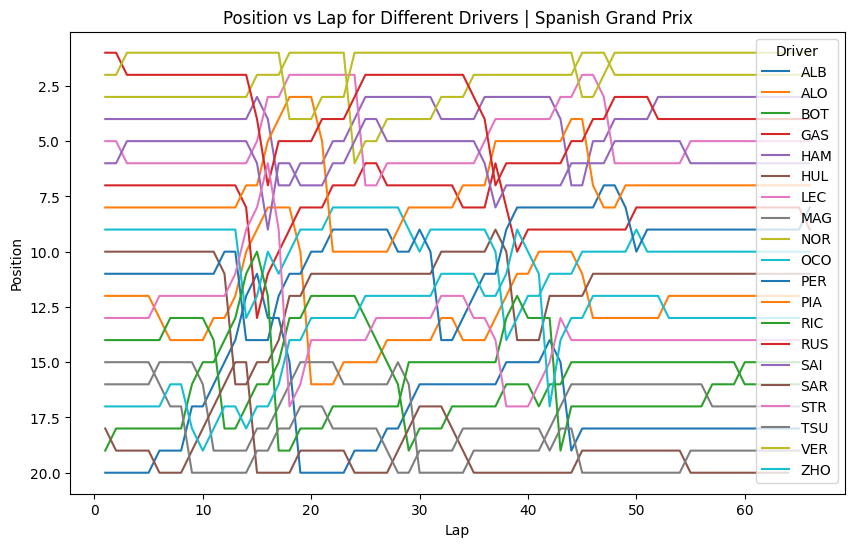

In [6]:
fig = get_positions_during_race('Spanish Grand Prix')

Could add another column for team for easier plot-information retrieval

Also add specific colors depending on driver-team (e.g. dark blue and blue for red bull)

In [13]:
def get_positions_during_race(event: str, drivers_abbrs: list=[]):
    '''
        Returns a matplotlib figure of the positions of drivers
        in a specific Grand Prix. Can filter drivers (optional)
    '''

    year = 2024
    session = fastf1.get_session(year, event, 'R')
    session.load(telemetry=False, weather=False)

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 6))

    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)

        abb = drv_laps['Driver'].iloc[0]
        style = fastf1.plotting.get_driver_style(identifier=abb,
                                                style=['color', 'linestyle'],
                                                session=session)

        ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                label=abb, **style)
    
    # Finalize the plot by setting y-limits that invert the y-axis so that position
    # one is at the top, set custom tick positions and axis labels.
    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')
    ax.set_title(f'Position vs Lap for Different Drivers | {event}')
    ax.legend(title='Driver')

    return fig


In [14]:
fig = get_positions_during_race('Spanish Grand Prix')

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
/Users/mike/miniconda3/envs/f1_assistant_mac/lib/python3.13/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_d

### Driver lead throughout race

In [ ]:
pos_df = pd.read_csv("data/gps_2024_season_laps.csv")
pos_df = pos_df[['Driver', 'LapNumber', 'Stint', 'Position', 'EventName']]
pos_df.head()

Driver  LapNumber  Stint  Position           EventName
1177    VER        1.0    1.0       1.0  Bahrain Grand Prix
1178    VER        2.0    1.0       1.0  Bahrain Grand Prix
1179    VER        3.0    1.0       1.0  Bahrain Grand Prix
1180    VER        4.0    1.0       1.0  Bahrain Grand Prix
1181    VER        5.0    1.0       1.0  Bahrain Grand Prix

In [ ]:
event = 'Dutch Grand Prix'
pos_df = pos_df[pos_df['EventName'] == event]

In [100]:
# pd.DataFrame(pos_df[['Position', 'Driver']].value_counts())

In [101]:
lead_df = pd.DataFrame(pos_df[pos_df['Position'] == 1]['Driver'].value_counts())

In [102]:
lead_df

count
Driver       
NOR        51
VER        17
PIA         4

In [ ]:
# Assuming your DataFrame is named df
max_driver = lead_df['count'].idxmax()

# Print the result
print(f"Driver who lead the race the most: {max_driver}")

Driver with the maximum count: NOR


Could make it more informative (e.g. pie chart for amount of laps led??)

Could also extend for season-multiple grand pri

## Overtakes

In [7]:
# # Here is the distinction if we want for one race otherwise for the whole season
# pos_df = pos_df[pos_df['EventName'] == 'Dutch Grand Prix']

In [16]:
over_df = pd.DataFrame()

events = pos_df['EventName'].unique()
drivers = pos_df['Driver'].unique()

over_df['Driver'] = drivers
over_df[events] = 0

In [17]:
over_df.head()

Driver  Bahrain Grand Prix  Saudi Arabian Grand Prix  Australian Grand Prix  \
0    VER                   0                         0                      0   
1    PER                   0                         0                      0   
2    SAI                   0                         0                      0   
3    LEC                   0                         0                      0   
4    RUS                   0                         0                      0   

   Japanese Grand Prix  Chinese Grand Prix  Miami Grand Prix  \
0                    0                   0                 0   
1                    0                   0                 0   
2                    0                   0                 0   
3                    0                   0                 0   
4                    0                   0                 0   

   Emilia Romagna Grand Prix  Monaco Grand Prix  Canadian Grand Prix  ...  \
0                          0                  0                    0  ...   
1                          0                  0                    0  ...   
2                          0                  0                    0  ...   
3                          0                  0                    0  ...   
4                          0                  0                    0  ...   

   British Grand Prix  Hungarian Grand Prix  Belgian Grand Prix  \
0                   0                     0                   0   
1                   0                     0                   0   
2                   0                     0                   0   
3                   0                     0                   0   
4                   0                     0                   0   

   Dutch Grand Prix  Italian Grand Prix  Azerbaijan Grand Prix  \
0                 0                   0                      0   
1                 0                   0                      0   
2                 0                   0                      0   
3                 0                   0                      0   
4                 0                   0                      0   

   Singapore Grand Prix  United States Grand Prix  Mexico City Grand Prix  \
0                     0                         0                       0   
1                     0                         0                       0   
2                     0                         0                       0   
3                     0                         0                       0   
4                     0                         0                       0   

   São Paulo Grand Prix  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 22 columns]

### Driver overtakes

In [18]:
# Iterate over the DataFrame grouped by each driver
for event in events:
    event_pos_df = pos_df[pos_df['EventName'] == event]

    for driver, group in event_pos_df.groupby('Driver'):
        # Sort by 'LapNumber' to ensure proper order
        group = group.sort_values(by='LapNumber')
        
        # Calculate when an overtake happens (position decrease)
        event_pos_df.loc[group.index, event] = (group['Position'].shift(1) > group['Position']).astype(int)

    # To find the total number of overtakes by each driver
    overtakes_per_driver = event_pos_df.groupby('Driver')[event].sum()

    # Add the new event column to over_df with values mapped from overtakes_per_driver
    over_df[event] = over_df['Driver'].map(overtakes_per_driver)

    # Replace any NaN values with 0 (if a driver doesn't appear in overtakes_per_driver)
    over_df[event] = over_df[event].fillna(0).astype(int)

/var/folders/9c/9pfxvdg55z52zckw2xcljktm0000gn/T/ipykernel_3268/3729388877.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_pos_df.loc[group.index, event] = (group['Position'].shift(1) > group['Position']).astype(int)
/var/folders/9c/9pfxvdg55z52zckw2xcljktm0000gn/T/ipykernel_3268/3729388877.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_pos_df.loc[group.index, event] = (group['Position'].shift(1) > group['Position']).astype(int)
/var/folders/9c/9pfxvdg55z52zckw2xcljktm0000gn/T/ipykern

In [19]:
over_df.head()

Driver  Bahrain Grand Prix  Saudi Arabian Grand Prix  Australian Grand Prix  \
0    VER                   0                         1                      0   
1    PER                   5                         3                     10   
2    SAI                   5                         0                      1   
3    LEC                   7                         2                      7   
4    RUS                   6                         3                      8   

   Japanese Grand Prix  Chinese Grand Prix  Miami Grand Prix  \
0                    2                   2                 1   
1                    8                   6                 4   
2                   10                   8                 3   
3                    9                   5                 2   
4                   14                   6                 7   

   Emilia Romagna Grand Prix  Monaco Grand Prix  Canadian Grand Prix  ...  \
0                          3                  1                    3  ...   
1                          9                  0                    8  ...   
2                          3                  1                    9  ...   
3                          3                  0                    2  ...   
4                          4                  1                    4  ...   

   British Grand Prix  Hungarian Grand Prix  Belgian Grand Prix  \
0                   5                     7                   9   
1                   8                    14                   3   
2                   4                     9                   8   
3                   5                     7                   7   
4                   2                    11                   8   

   Dutch Grand Prix  Italian Grand Prix  Azerbaijan Grand Prix  \
0                 3                   7                      5   
1                 6                   9                      3   
2                 9                   7                      5   
3                 5                   5                      1   
4                 4                  13                      7   

   Singapore Grand Prix  United States Grand Prix  Mexico City Grand Prix  \
0                     1                         2                       8   
1                     4                         6                       6   
2                     9                         3                       2   
3                     6                         2                       2   
4                     4                        14                       5   

   São Paulo Grand Prix  
0                     9  
1                     8  
2                     6  
3                     7  
4                     2  

[5 rows x 22 columns]

In [20]:
over_df['DriverTotalOvertakes'] = over_df[over_df.columns[1:]].sum(axis=1)

In [22]:
over_df.tail()

Driver  Bahrain Grand Prix  Saudi Arabian Grand Prix  \
18    BOT                   7                         2   
19    SAR                   2                         3   
20    BEA                   0                         7   
21    COL                   0                         0   
22    LAW                   0                         0   

    Australian Grand Prix  Japanese Grand Prix  Chinese Grand Prix  \
18                      8                   10                   5   
19                      0                    9                  12   
20                      0                    0                   0   
21                      0                    0                   0   
22                      0                    0                   0   

    Miami Grand Prix  Emilia Romagna Grand Prix  Monaco Grand Prix  \
18                 5                          6                  5   
19                 2                          8                  4   
20                 0                          0                  0   
21                 0                          0                  0   
22                 0                          0                  0   

    Canadian Grand Prix  ...  Hungarian Grand Prix  Belgian Grand Prix  \
18                    7  ...                    11                  11   
19                    1  ...                    10                   7   
20                    0  ...                     0                   0   
21                    0  ...                     0                   0   
22                    0  ...                     0                   0   

    Dutch Grand Prix  Italian Grand Prix  Azerbaijan Grand Prix  \
18                 5                  10                      5   
19                 6                   0                      0   
20                 0                   0                      8   
21                 0                  10                      7   
22                 0                   0                      0   

    Singapore Grand Prix  United States Grand Prix  Mexico City Grand Prix  \
18                     8                         7                      11   
19                     0                         0                       0   
20                     0                         0                       0   
21                     5                        10                      11   
22                     0                        10                      12   

    São Paulo Grand Prix  DriverTotalOvertakes  
18                     7                   157  
19                     0                    81  
20                    12                    27  
21                     2                    45  
22                     5                    27  

[5 rows x 23 columns]

In [23]:
over_df[over_df.columns[1:]].sum(axis=0)

Bahrain Grand Prix            153
Saudi Arabian Grand Prix       51
Australian Grand Prix         145
Japanese Grand Prix           136
Chinese Grand Prix            185
Miami Grand Prix              107
Emilia Romagna Grand Prix     116
Monaco Grand Prix              30
Canadian Grand Prix           119
Spanish Grand Prix            204
Austrian Grand Prix           171
British Grand Prix             96
Hungarian Grand Prix          183
Belgian Grand Prix            171
Dutch Grand Prix              129
Italian Grand Prix            164
Azerbaijan Grand Prix         116
Singapore Grand Prix          114
United States Grand Prix      132
Mexico City Grand Prix        134
São Paulo Grand Prix           98
DriverTotalOvertakes         2754
dtype: int64

Input for function for specific driver/grand prix and output what needed